In [449]:
# Observation data source from FMI (https://en.ilmatieteenlaitos.fi/download-observations)
import pandas as pd
# Daily observations for Espoo cirt
weather = pd.read_csv("espoo.csv", index_col="DATE")

In [450]:

weather

,STATION,PRCP,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2
...,...,...,...,...,...,...
2024-2-6,Espoo,0.4,34,-4.9,-1.9,-5.6
2024-2-7,Espoo,-1.0,35,-10.6,-5.5,-14.7
2024-2-8,Espoo,-1.0,34,-14.8,-10.3,-19.4


In [451]:
# Get the percentage of the null values
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
null_pct

STATION    0.0
PRCP       0.0
SNWD       0.0
TAVG       0.0
TMAX       0.0
TMIN       0.0
dtype: float64

In [452]:
# Get the columns that have less than 5% null values
valid_columns = weather.columns[null_pct < .05]
valid_columns

Index(['STATION', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

In [453]:
weather = weather[valid_columns].copy()
weather.columns = weather.columns.str.lower()

In [454]:
weather

,station,prcp,snwd,tavg,tmax,tmin
DATE,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2
...,...,...,...,...,...,...
2024-2-6,Espoo,0.4,34,-4.9,-1.9,-5.6
2024-2-7,Espoo,-1.0,35,-10.6,-5.5,-14.7
2024-2-8,Espoo,-1.0,34,-14.8,-10.3,-19.4


In [455]:
weather = weather.ffill()
weather.apply(lambda x: (x == 9999).sum())

station    0
prcp       0
snwd       0
tavg       0
tmax       0
tmin       0
dtype: int64

In [456]:
weather.index

Index(['2013-11-26', '2013-11-27', '2013-11-28', '2013-11-29', '2013-11-30',
       '2013-12-1', '2013-12-2', '2013-12-3', '2013-12-4', '2013-12-5',
       ...
       '2024-2-1', '2024-2-2', '2024-2-3', '2024-2-4', '2024-2-5', '2024-2-6',
       '2024-2-7', '2024-2-8', '2024-2-9', '2024-2-10'],
      dtype='object', name='DATE', length=3729)

In [457]:
weather.index = pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()

DATE
2013     36
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024     41
Name: count, dtype: int64

<Axes: xlabel='DATE'>

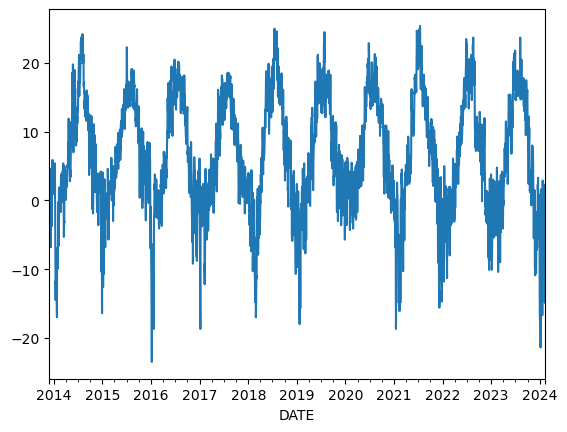

In [458]:
# plot average temperature for exercise
weather["tavg"].plot()

In [459]:
weather["target"] = weather.shift(-1)["tavg"]
weather = weather.ffill()

In [460]:
weather

,station,prcp,snwd,tavg,tmax,tmin,target
DATE,,,,,,,
2013-11-26,Espoo,1.5,0,-2.0,2.7,-6.4,4.7
2013-11-27,Espoo,-1.0,0,4.7,5.8,2.7,4.0
2013-11-28,Espoo,-1.0,0,4.0,7.0,1.6,-1.9
2013-11-29,Espoo,-1.0,0,-1.9,2.7,-5.2,-3.2
2013-11-30,Espoo,1.0,0,-3.2,2.4,-9.2,1.8
...,...,...,...,...,...,...,...
2024-02-06,Espoo,0.4,34,-4.9,-1.9,-5.6,-10.6
2024-02-07,Espoo,-1.0,35,-10.6,-5.5,-14.7,-14.8
2024-02-08,Espoo,-1.0,34,-14.8,-10.3,-19.4,-14.9


In [461]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [462]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

Index(['prcp', 'snwd', 'tavg', 'tmax', 'tmin'], dtype='object')

In [463]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [464]:
predictions = backtest(weather, rr, predictors)
predictions

,actual,prediction,diff
DATE,,,
2023-11-24,-9.5,-1.334263,8.165737
2023-11-25,-10.0,-8.959183,1.040817
2023-11-26,-10.9,-8.997316,1.902684
2023-11-27,-4.0,-9.859295,5.859295
2023-11-28,-1.6,-2.231255,0.631255
...,...,...,...
2024-02-06,-10.6,-5.577093,5.022907
2024-02-07,-14.8,-9.909647,4.890353
2024-02-08,-14.9,-13.579577,1.320423


In [465]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

2.703159421462983

In [466]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2024-01-07,-6.7,-20.342397,13.642397
2023-12-30,-13.8,-3.471119,10.328881
2024-01-20,-6.4,-16.149225,9.749225
2023-11-24,-9.5,-1.334263,8.165737
2024-01-19,-16.7,-9.055113,7.644887
...,...,...,...
2023-12-24,-2.1,-2.360185,0.260185
2023-12-17,1.5,1.719035,0.219035
2023-12-26,-3.4,-3.265083,0.134917


In [467]:
pd.Series(rr.coef_, index=predictors)

prcp    0.030568
snwd   -0.021800
tavg    1.282218
tmax   -0.041870
tmin   -0.317577
dtype: float64

In [468]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather
    
rolling_horizons = [10, 20]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

In [469]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

In [470]:
weather = weather.iloc[20:,:]
weather

,station,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2013-12-16,Espoo,1.7,0,4.6,5.3,2.8,4.7,2.31,1.294372,-3.02,...,-2.710,-2.033210,0.445,2.820225,2.850000,5.300000,-2.756250,2.800000,0.681250,1.700000
2013-12-17,Espoo,-1.0,0,4.7,7.4,2.9,1.7,2.96,1.500000,-2.53,...,-2.700,-2.074074,0.445,-3.247191,3.117647,7.400000,-2.423529,2.900000,0.582353,-1.000000
2013-12-18,Espoo,-1.0,0,1.7,3.2,0.0,2.4,3.48,-0.080460,-2.07,...,-2.780,-1.000000,0.445,-3.247191,3.122222,3.200000,-2.288889,0.000000,0.494444,-1.000000
2013-12-19,Espoo,3.6,0,2.4,3.1,1.6,3.5,4.19,-0.260143,-1.05,...,-2.440,-1.655738,0.675,4.333333,3.121053,3.100000,-2.084211,1.600000,0.657895,3.600000
2013-12-20,Espoo,1.6,0,3.5,5.3,1.6,4.4,4.46,0.188341,0.23,...,-1.900,-1.842105,0.705,1.269504,3.230000,5.300000,-1.900000,1.600000,0.705000,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,Espoo,0.4,34,-4.9,-1.9,-5.6,-10.6,1.92,-1.989583,-1.47,...,-4.655,0.203008,1.265,-0.683794,0.566319,-1.309091,-4.394792,-7.800000,1.546528,0.945455
2024-02-07,Espoo,-1.0,35,-10.6,-5.5,-14.7,-14.8,1.08,-6.092593,-2.80,...,-5.070,1.899408,0.780,-2.282051,0.545329,-1.063636,-4.430450,-7.572727,1.537716,0.445455
2024-02-08,Espoo,-1.0,34,-14.8,-10.3,-19.4,-14.9,-0.31,32.225806,-4.90,...,-5.345,2.629560,0.780,-2.282051,0.507931,-0.436364,-4.482069,-5.427273,1.528966,1.027273


In [471]:
weather = weather.fillna(0)
weather.describe()

,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,rolling_10_tmin_pct,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3.709000e+03,...,3709.000000,3.709000e+03,3709.000000,3.709000e+03,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,1.464734,3.510111,6.646643,10.147722,3.123753,6.641871,10.158541,-0.211615,3.135338,-4.290912e+12,...,3.135212,1.453857e+12,1.466351,-3.288555e+12,10.143399,10.153065,3.308081,3.297180,1.407566,1.434509
std,4.580835,9.955820,8.283855,9.135308,7.958584,8.290130,8.722573,12.319080,7.262560,2.338424e+14,...,7.034420,7.023889e+13,1.473041,2.002781e+14,8.015980,8.319580,6.311177,6.697571,0.749134,2.391455
min,-1.000000,-1.000000,-23.500000,-21.100000,-26.200000,-23.500000,-11.680000,-491.000000,-18.300000,-1.407375e+16,...,-17.250000,-1.281000e+03,-1.000000,-1.219725e+16,-4.600000,-13.900000,-8.683529,-19.700000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,2.900000,-1.500000,1.000000,2.950000,-0.219616,-1.680000,-5.419847e-01,...,-1.920000,-6.774194e-01,0.365000,-1.677966e+00,3.467949,3.100000,-1.611111,-1.800000,0.800000,-0.080000
50%,-1.000000,-1.000000,5.900000,9.500000,2.600000,5.900000,9.330000,-0.010903,2.170000,-1.234568e-02,...,2.200000,-3.601108e-02,1.245000,-8.245614e-01,9.059659,8.850000,1.695349,2.144444,1.479762,0.870000
75%,1.900000,2.000000,13.700000,18.100000,9.600000,13.700000,18.210000,0.197224,9.650000,4.335060e-01,...,9.580000,4.439324e-01,2.355000,1.051756e+00,17.026829,18.100000,9.125000,9.383333,1.862676,2.255556
max,60.100000,56.000000,25.400000,32.800000,22.900000,25.400000,28.240000,449.000000,19.320000,8.314338e+14,...,18.115000,4.067767e+15,8.330000,2.590000e+02,26.828571,29.800000,16.814286,21.300000,4.711111,38.200000


In [472]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

In [473]:
predictions = backtest(weather, rr, predictors)

/Users/rehabaam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.9715e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [474]:
mean_squared_error(predictions["actual"], predictions["prediction"])

15.063804883918955

In [475]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2024-01-07,-6.7,-18.423673,11.723673
2023-12-30,-13.8,-3.473628,10.326372
2024-01-20,-6.4,-15.025978,8.625978
2024-01-19,-16.7,-8.971100,7.728900
2024-01-15,-16.0,-8.556676,7.443324
2024-01-06,-21.4,-13.960996,7.439004
2024-02-07,-14.8,-8.809543,5.990457
2024-02-06,-10.6,-5.055259,5.544741
2024-01-27,1.9,-3.039039,4.939039


In [476]:
weather.loc["2024-01-01": "2024-02-11"]

,station,prcp,snwd,tavg,tmax,tmin,target,rolling_10_tmax,rolling_10_tmax_pct,rolling_10_tmin,...,rolling_20_tmin,rolling_20_tmin_pct,rolling_20_prcp,rolling_20_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2024-01-01,Espoo,-1.0,27,-16.5,-14.7,-18.0,-17.3,-1.96,6.500000,-6.17,...,-4.940,2.643725,2.430,-1.411523,-0.809003,1.527273,-5.630868,-3.136364,1.770740,0.227273
2024-01-02,Espoo,0.1,27,-17.3,-15.4,-19.8,-17.4,-3.71,3.150943,-8.16,...,-5.610,2.529412,2.310,-0.956710,-0.855769,-0.136364,-5.676282,-4.463636,1.765385,2.527273
2024-01-03,Espoo,-1.0,27,-17.4,-15.3,-20.2,-17.8,-5.31,1.881356,-9.84,...,-6.325,2.193676,2.250,-1.444444,-0.901917,-1.663636,-5.722684,-4.890909,1.756550,1.700000
2024-01-04,Espoo,0.1,30,-17.8,-16.4,-19.6,-16.3,-6.87,1.387191,-11.53,...,-6.810,1.878120,2.245,-0.955457,-0.951274,-1.227273,-5.766879,-6.881818,1.751274,0.527273
2024-01-05,Espoo,2.7,31,-16.3,-15.6,-17.9,-16.0,-8.16,0.911765,-12.68,...,-7.280,1.458791,2.320,0.163793,-0.997778,-3.881818,-5.805397,-8.400000,1.754286,1.572727
2024-01-06,Espoo,-1.0,33,-16.0,-13.5,-18.3,-21.4,-9.50,0.421053,-13.97,...,-8.230,1.223572,2.320,-1.431034,-1.037342,-5.154545,-5.844937,-10.545455,1.745570,-0.209091
2024-01-07,Espoo,-1.0,32,-21.4,-18.0,-23.6,-6.7,-11.32,0.590106,-15.80,...,-9.450,1.497354,2.110,-1.473934,-1.090852,-3.518182,-5.900946,-9.063636,1.736909,1.527273
2024-01-08,Espoo,-1.0,32,-6.7,-2.8,-23.1,0.6,-11.68,-0.760274,-18.09,...,-10.645,1.170033,1.980,-1.505051,-1.096226,-0.190909,-5.955031,-6.990909,1.728302,2.418182
2024-01-09,Espoo,-1.0,32,0.6,2.5,-3.9,1.6,-11.49,-1.217581,-17.91,...,-10.625,-0.632941,1.680,-1.595238,-1.084953,0.472727,-5.948589,-3.645455,1.719749,2.072727


<Axes: xlabel='diff'>

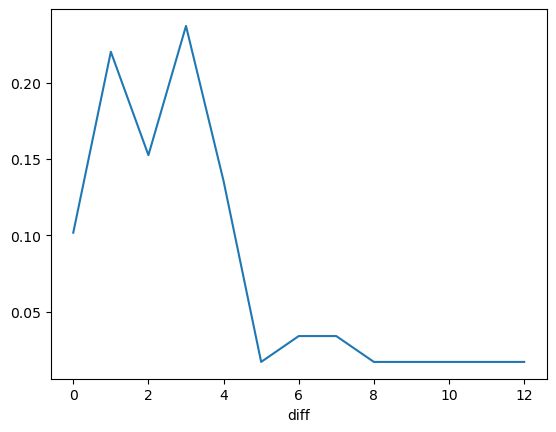

In [477]:
(predictions["diff"].round().value_counts().sort_index() / predictions.shape[0]).plot()

In [478]:
predictions

,actual,prediction,diff
DATE,,,
2023-12-14,-5.6,-4.871411,0.728589
2023-12-15,-0.7,-4.311733,3.611733
2023-12-16,2.3,0.391019,1.908981
2023-12-17,1.5,0.698314,0.801686
2023-12-18,3.3,0.232640,3.067360
2023-12-19,-1.1,2.130728,3.230728
2023-12-20,0.3,-1.122466,1.422466
2023-12-21,0.9,1.102145,0.202145
2023-12-22,0.9,0.148530,0.751470
